# A blue book for Bulldozers

![ ](bulldozer.jpg " ")

## Overview

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

## Data

For this competition, we are predicting the sale price of bulldozers sold at auctions.

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have. The descriptions all start with "machine configuration" in the data dictionary. Some product types do not have a particular option, so all the records for that option variable will be null for that product type. Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [260]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
from treeinterpreter import treeinterpreter as ti
import waterfall_chart

In [3]:
DATA_DIR = "data/"
os.listdir(DATA_DIR)

['df_process.frt',
 'Valid.csv',
 'category_mapper',
 '.DS_Store',
 'merge_raw.frt',
 'df_merge_3.csv',
 'df_keep.frt',
 'train.frt',
 'df_process_2.frt',
 'Machine_Appendix.csv',
 'Train.csv',
 'df_keep.csv',
 'df_merge.frt',
 'df_merge_2.frt',
 'df_merge_3.frt',
 'dropped_cols.frt',
 'appendix.frt',
 'df_merge_4.frt',
 'keep_cols',
 'train.ftr']

# Load data

In [4]:
#%time df_train_raw = pd.read_csv(f"{DATA_DIR}Train.csv", low_memory=False, parse_dates=["saledate"])
#%time df_appendix_raw = pd.read_csv(f"{DATA_DIR}Machine_Appendix.csv", low_memory=False)

CPU times: user 1min 32s, sys: 764 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 954 ms, sys: 141 ms, total: 1.09 s
Wall time: 1.1 s


In [5]:
#df_train_raw.to_feather(f"{DATA_DIR}Train.frt")
#df_appendix_raw.to_feather(f"{DATA_DIR}appendix.frt")

In [6]:
%time df_train_raw = pd.read_feather(f"{DATA_DIR}Train.frt")
%time df_appendix_raw = pd.read_feather(f"{DATA_DIR}appendix.frt")

CPU times: user 642 ms, sys: 234 ms, total: 876 ms
Wall time: 880 ms
CPU times: user 261 ms, sys: 93.3 ms, total: 354 ms
Wall time: 352 ms


We merge the two dataframes by the MachineID key

In [7]:
df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")
print(df_train_raw.columns)
print(df_appendix_raw.columns)

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')
Index(['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseM

Merge the two dataframes on the key MachineID, we'll deal later with the duplicate columns fiModelDesc, ...

In [8]:
df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")

In [9]:
df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")

In [10]:
df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")

Save memory by deleting the two originals dataframes

In [11]:
del df_train_raw
del df_appendix_raw

In [12]:
df_merge_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID_x', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc_x', 'fiBaseModel_x', 'fiSecondaryDesc_x',
       'fiModelSeries_x', 'fiModelDescriptor_x', 'ProductSize',
       'fiProductClassDesc_x', 'state', 'ProductGroup_x', 'ProductGroupDesc_x',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'ModelID_y', 'fiModelDesc_y', 'fiBaseModel_y', 'fiSe

Now let deal with the duplicate columns.
From the files descriptions we can deduce that the values in the appendix file are more accurate.
But first let have a look at the missing values of each duplicate columns, and verify that we can safely drop columns from the train dataframe

In [13]:
duplicate_columns = ["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries",
                     "fiModelDescriptor", "fiProductClassDesc", "ProductGroup", "ProductGroupDesc", "ModelID"]
temp = {col_name: df_merge_raw[col_name+"_x"].isnull().sum() == df_merge_raw[col_name+"_y"].isnull().sum() for col_name in duplicate_columns}
temp

{'ModelID': True,
 'ProductGroup': True,
 'ProductGroupDesc': True,
 'fiBaseModel': True,
 'fiModelDesc': True,
 'fiModelDescriptor': False,
 'fiModelSeries': False,
 'fiProductClassDesc': True,
 'fiSecondaryDesc': False}

In [14]:
ok_columns = [key for key, val in temp.items() if val == True]
{col_name: [df_merge_raw[col_name+"_x"].isnull().sum(), df_merge_raw[col_name+"_y"].isnull().sum()] for col_name in duplicate_columns}

{'ModelID': [0, 0],
 'ProductGroup': [0, 0],
 'ProductGroupDesc': [0, 0],
 'fiBaseModel': [0, 0],
 'fiModelDesc': [0, 0],
 'fiModelDescriptor': [329206, 326906],
 'fiModelSeries': [344217, 343515],
 'fiProductClassDesc': [0, 0],
 'fiSecondaryDesc': [137191, 135593]}

Some "duplicate columns" does not have the same numbers of missing values, but there are less missing values in columns from the appendix file.
Hence we can drop safely the columns that originate from the train file.

In [15]:
df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)

For convinience we remove the _y of each duplicate columns.

In [16]:
for col_name in duplicate_columns:
    df_merge[col_name] = df_merge[col_name+"_y"]
    df_merge.drop(col_name+"_y", axis=1, inplace=True)

In [17]:
# Let save the dataframe
df_merge.to_feather(f"{DATA_DIR}df_merge.frt")

In [18]:
del df_merge_raw

## Missing values and features engineering

In [19]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")

In [20]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        === Inputs ===
        df: dataframe to analyze
        keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        === Outputs ===
        res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [21]:
missing_values_stats(df_merge)

,Total,Percentage
Pushblock,375906,93.71
Tip_Control,375906,93.71
Engine_Horsepower,375906,93.71
Blade_Extension,375906,93.71
Blade_Width,375906,93.71
Enclosure_Type,375906,93.71
Scarifier,375895,93.71
Hydraulics_Flow,357763,89.19
Grouser_Tracks,357763,89.19
Coupler_System,357667,89.17


### Years
From description MfgYear should be the correct version of YearMade. Let compare them to check if we can drop YearMade safely.

In [22]:
(df_merge["YearMade"] != df_merge["MfgYear"]).sum()

33864

The two columns have 33864 different entries.
Before dropping YearMade, let see if some weird values from MfgYear can be correct using YearMade.

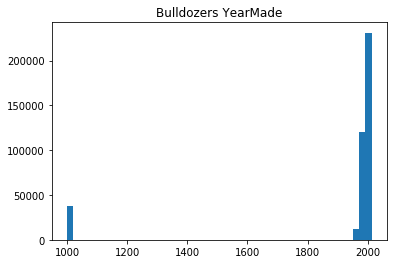

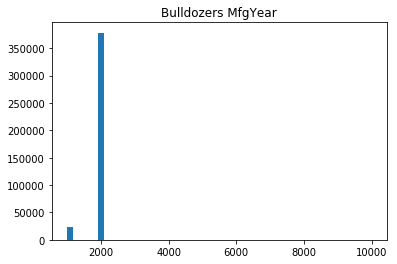

In [23]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

Clearly their are some weird values: 
 - In MfgYear there are some values in the 10000's, we should replace them with the values in YearMade
 - In both features there are some bulldozers build in the 1000's which is obviously wrong, let see if there are the same in each columns

In [24]:
df_merge[df_merge.MfgYear > 2012]

,SalesID,SalePrice,MachineID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,ProductSize,...,PrimaryUpper,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,ModelID
168998,1579170,20500,884218,132,22.0,1996,NaN,None,2009-11-21,Compact,...,1000000.0,848G,848,G,None,None,"Skidder, Wheel - 161.0 + Horsepower",SKID,Skidders,4839


In [25]:
df_merge.loc[df_merge.MfgYear > 2012, "MfgYear"] = 1996

Only one incorrect value in MfgYear greater than 2012, we replaced it by the YearMade value.

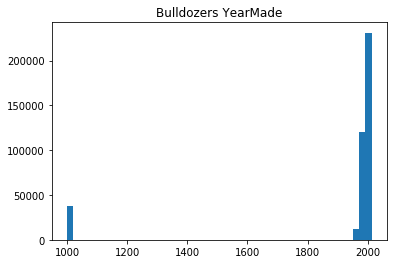

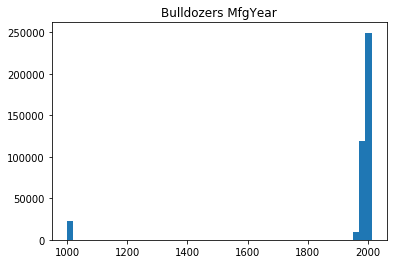

In [26]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

In [27]:
print("YearMade < 1900: ", len(df_merge[df_merge.YearMade < 1900]))
print("MfgYear < 1900: ", len(df_merge[df_merge.MfgYear < 1900]))

YearMade < 1900:  38185
MfgYear < 1900:  22554


We learn from the above graphs that there are more values lesser than 1900 in YearMade than MfgYear.
We need to check if the the values in MfgYear are contains in YearMade.

In [28]:
MfgYear_idx = df_merge[df_merge.MfgYear < 1900].index
YearMade_idx = df_merge[df_merge.YearMade < 1900].index
[e for e in MfgYear_idx if e not in YearMade_idx]

[]

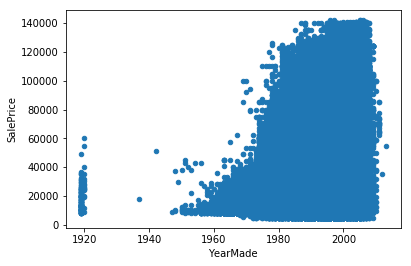

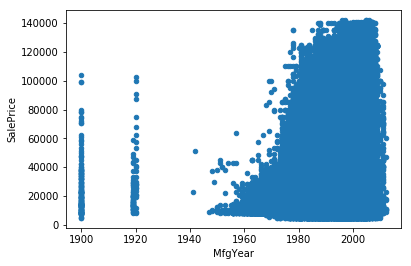

In [29]:
df_merge[df_merge.YearMade >= 1900].plot("YearMade", "SalePrice", "scatter")
plt.show()
df_merge[df_merge.MfgYear >= 1900].plot("MfgYear", "SalePrice", "scatter")

From the above graphs we can see that there others irregularities in the values of YearMade and MfgYear.
Futhermore, there is a line of values dated at 1900 in MfgYear that not appers in YearMade.
We'll replace the values of the 1900 line in MfgYear by the values in YearMade.

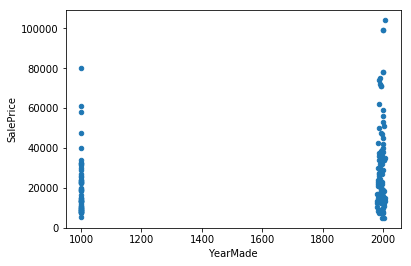

In [30]:
df_merge.iloc[df_merge[df_merge.MfgYear == 1900].index].plot("YearMade", "SalePrice", "scatter")

In [31]:
df_merge["MfgYear_correct"] = df_merge["MfgYear"]

In [32]:
df_merge.loc[df_merge.MfgYear == 1900, "MfgYear_correct"] = df_merge[df_merge.MfgYear == 1900]["YearMade"]

In [33]:
print("values <= 1920:", len(df_merge[df_merge.MfgYear_correct <=1920]), "  ", np.round(len(df_merge[df_merge.MfgYear_correct <=1920])/len(df_merge), 3), "%")

values <= 1920: 22695    0.057 %


Now to deal with the 1920's line, there is to much incorrect values to manually correct them. They represents less than 0.06% of the dataset, we can drop them without risk.

In [34]:
dropped_columns = pd.DataFrame()
dropped_columns["YearMade"] = df_merge["YearMade"]
dropped_columns["MfgYear"] = df_merge["MfgYear"]

In [35]:
df_merge.drop(["YearMade", "MfgYear"], axis=1, inplace=True)

In [36]:
df_merge.drop(df_merge[df_merge.MfgYear_correct <= 1920].index, axis=0, inplace=True)

In [37]:
df_merge["MfgYear_correct"] = df_merge["MfgYear_correct"].dropna()

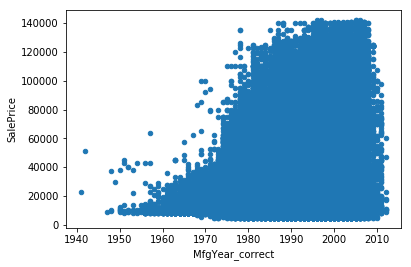

In [38]:
df_merge.plot("MfgYear_correct", "SalePrice", "scatter")

Finally we have a correct range of values for the manufacturing date. 

In [39]:
# reset index
df_merge = df_merge.reset_index(drop=True)

In [40]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")
dropped_columns.to_feather(f"{DATA_DIR}dropped_cols.frt")

In [41]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with dates

In [42]:
def date_infos(df_in, col_name, drop=True, inplace=False):
    """
    Extract infos (Year, Month, Day, Dayofweek,...) from a column containning dates. 
    
    === Inputs ===
    df_in: input dataframe.
    col_name: name of the column containning dates.
    drop: boolean that indicate if the column col_name has to be dropped.
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    A data frame.
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    # Convert the date column to right dtype if needed
    if not np.issubdtype(df[col_name].dtype, np.datetime64):
        df[col_name] = pd.to_datetime(df[col_name], infer_datetime_format=True)
    new_idx_prefix = re.sub('[Dd]ate$', '', col_name)
    for c in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
              'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[new_idx_prefix+"_"+c] = getattr(df[col_name].dt, c.lower())
    df[new_idx_prefix+'_Elapsed'] = df[col_name].astype(np.int64) // 10**9
    if drop:
        df.drop(col_name, axis=1, inplace=True)
    return df

In [43]:
# Extract all infos from the columns date
df_merge = date_infos(df_merge, "saledate")

In [44]:
df_merge.head()

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Day,sale_Dayofweek,sale_Dayofyear,sale_Is_month_end,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed
0,1139246,66000,999089,121,3.0,68.0,Low,None,Alabama,None,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,57000,117657,121,3.0,4640.0,Low,Medium,North Carolina,None,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,10000,434808,121,3.0,2838.0,High,None,New York,None,...,26,3,57,False,False,False,False,False,False,1077753600
3,1398858,12000,434808,132,2.0,NaN,None,None,Kentucky,None,...,23,4,114,False,False,False,False,False,False,1082678400
4,1398859,12500,434808,132,2.0,NaN,None,None,Texas,None,...,17,2,77,False,False,False,False,False,False,1079481600


One feature that is interesting is to compute the age of a machine at the day of the sale.

In [45]:
df_merge["age"] = df_merge["sale_Year"] - df_merge["MfgYear_correct"]

Let check if there is some machine with a negative age.

In [46]:
print("machine age < 0: ", len(df_merge[df_merge.age < 0]), np.round(len(df_merge[df_merge.age < 0])/len(df_merge), 5), "%")

machine age < 0:  2283 0.00603 %


There is 2283 machines with age under 0 represeting about 0.006% of the dataset. This is too much entries to manually correct them, but the number is small enought that we can safely drop them.

In [47]:
df_merge.drop(df_merge[df_merge.age < 0].index, axis=0, inplace=True)

In [48]:
df_merge = df_merge.reset_index(drop=True)

In [49]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with categorical features
We start by seperate into two groups the features: categorical and numerical.
Then we study briefly the categorical features, we remark that some features have a "None or Unspecified" category. So when possible we replace missing categories by it.

In [50]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

In [51]:
numerical_features = [col_name for col_name in df_merge.columns if not (pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype))]
categorical_features = [col_name for col_name in df_merge.columns if pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype)]

In [52]:
numerical_features

['SalesID',
 'SalePrice',
 'MachineID',
 'datasource',
 'auctioneerID',
 'MachineHoursCurrentMeter',
 'fiManufacturerID',
 'PrimaryLower',
 'PrimaryUpper',
 'ModelID',
 'MfgYear_correct',
 'sale_Year',
 'sale_Month',
 'sale_Week',
 'sale_Day',
 'sale_Dayofweek',
 'sale_Dayofyear',
 'sale_Is_month_end',
 'sale_Is_month_start',
 'sale_Is_quarter_end',
 'sale_Is_quarter_start',
 'sale_Is_year_end',
 'sale_Is_year_start',
 'sale_Elapsed',
 'age']

We see above that some numerical features missclassified and should be categorical.

In [53]:
sorted({feat: len(df_merge[feat].unique()) for feat in numerical_features}.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('MachineHoursCurrentMeter', 14933),
 ('ModelID', 5300),
 ('sale_Elapsed', 3894),
 ('SalePrice', 881),
 ('sale_Dayofyear', 360),
 ('fiManufacturerID', 101),
 ('PrimaryLower', 74),
 ('PrimaryUpper', 71),
 ('MfgYear_correct', 68),
 ('age', 63),
 ('sale_Week', 53),
 ('auctioneerID', 31),
 ('sale_Day', 31),
 ('sale_Year', 23),
 ('sale_Month', 12),
 ('sale_Dayofweek', 7),
 ('datasource', 5),
 ('sale_Is_month_end', 2),
 ('sale_Is_month_start', 2),
 ('sale_Is_quarter_end', 2),
 ('sale_Is_quarter_start', 2),
 ('sale_Is_year_end', 2),
 ('sale_Is_year_start', 1)]

In [54]:
# Features with ID should be categorical
categorical_features.extend(["MachineID", "ModelID", "SalesID", "auctioneerID", "datasource", "fiManufacturerID"])

In [55]:
# Convert the supposed categorical features into categeory in the dataframe
for feat in categorical_features:
    df_merge[feat] = df_merge[feat].astype("category")

In [56]:
temp = {feat: len(df_merge[feat].unique()) for feat in df_merge.columns if pd.api.types.is_categorical(df_merge[feat])}
sorted(temp.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('ModelID', 5300),
 ('fiModelDesc', 5069),
 ('fiBaseModel', 1971),
 ('fiSecondaryDesc', 183),
 ('fiProductClassDesc', 153),
 ('fiModelDescriptor', 152),
 ('fiModelSeries', 142),
 ('fiManufacturerID', 101),
 ('fiManufacturerDesc', 101),
 ('state', 53),
 ('ProductGroup', 37),
 ('ProductGroupDesc', 37),
 ('auctioneerID', 31),
 ('Stick_Length', 29),
 ('Undercarriage_Pad_Width', 20),
 ('Tire_Size', 18),
 ('Hydraulics', 13),
 ('Blade_Type', 11),
 ('Transmission', 9),
 ('Travel_Controls', 8),
 ('PrimarySizeBasis', 8),
 ('ProductSize', 7),
 ('Enclosure', 7),
 ('Blade_Width', 7),
 ('Steering_Controls', 6),
 ('datasource', 5),
 ('Drive_System', 5),
 ('Pad_Type', 5),
 ('Ripper', 5),
 ('Differential_Type', 5),
 ('UsageBand', 4),
 ('Ride_Control', 4),
 ('Enclosure_Type', 4),
 ('Tip_Control', 4),
 ('Coupler', 4),
 ('Hydraulics_Flow', 4),
 ('Thumb', 4),
 ('Pattern_Changer', 4),
 ('Grouser_Type', 4),
 ('Forks', 3),
 ('Stick', 3),
 ('Turbocharged', 3),
 ('

In [57]:
df_merge["Backhoe_Mounting"].unique()

[NaN, None or Unspecified, Yes]
Categories (2, object): [None or Unspecified, Yes]

In [58]:
# For each categorical features, if a "None or Unspecified" category exist we replace evry missing values by it
for col_name in df_merge.columns:
    if pd.api.types.is_categorical_dtype(df_merge[col_name]):
        if df_merge[col_name].isnull().sum() > 0 and "None or Unspecified" in df_merge[col_name].unique():
            df_merge[col_name] = df_merge[col_name].fillna("None or Unspecified")

In [59]:
# Save mapper from code to category and vice-versa for each categorical features
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}
category_inv_mapper = {col_name: {idx: code for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}

In [60]:
def numericalize(df_in, inplace=False):
    """
    Convert the categorical features of the dataframe into numerical values.
    
    === Inputs ===
    df_in: dataframe to numericalize
    inplace: boolean that indicate if the transformation is done inplace
    
    === Output ===
    a dataframe with categorical features convert into numerical features
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[col_name] = col.cat.codes + 1 # +1 because Nan have -1 code
    return df

In [61]:
numericalize(df_merge, inplace=True);

Now every categorical features have been dealt with, ie, missing values replaced and category converted in numbers.
### Dealing we numerical features

In [62]:
def fix_numerical_missing_values(df_in, inplace=False):
    """
    Replace missing values of a numerical feature by the median of the column.
    Plus, add boolean column that indicate if the value was missing.
    
    === Inputs ===
    df_in: dataframe to fix
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    a dataframe without missing values in the numerical features. 
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_numeric_dtype(col):
            if col.isnull().sum():
                df[col_name+"_na"] = col.isnull()
                df[col_name] = col.fillna(col.dropna().median())
    return df

In [63]:
df_merge = fix_numerical_missing_values(df_merge)

In [64]:
missing_values_stats(df_merge)

,Total,Percentage


Finally no more missing values in the data frame.
Before building a model, let draw a pairplot of the dataframe.

In [65]:
df_merge.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'datasource', 'auctioneerID',
       'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'state',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'fiManufacturerID', 'fiManufacturerDesc', 'PrimarySizeBasis',
       'PrimaryLower', 'PrimaryUpper', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'ModelID',


In [66]:
# Error with feather on windows 10
df_merge.to_csv(f"{DATA_DIR}df_merge_3.csv", index=False)

## Model baseline random forest

In [67]:
df_merge = pd.read_csv(f"{DATA_DIR}df_merge_3.csv")

In [68]:
df_merge.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'datasource', 'auctioneerID',
       'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'state',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'fiManufacturerID', 'fiManufacturerDesc', 'PrimarySizeBasis',
       'PrimaryLower', 'PrimaryUpper', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'ModelID',


In [69]:
sale_price = np.log(df_merge["SalePrice"])

In [70]:
dropped_cols = pd.DataFrame()
dropped_cols["SalePrice"] = df_merge["SalePrice"]

In [71]:
df_merge.drop("SalePrice", axis=1, inplace=True)

In [72]:
def split_vals(a, n):
    """
    Split the frame into two frames of size len(a)-n et n
    """
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_merge)-n_valid
x_train, x_valid = split_vals(df_merge, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((364147, 75), (364147,), (12000, 75), (12000,))

In [73]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)

%time random_forest.fit(x_train, y_train)

CPU times: user 9min 12s, sys: 4.61 s, total: 9min 17s
Wall time: 1min 28s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [74]:
def rmse(x, y):
    """
    Cost function for the evaluation
    """
    return math.sqrt(((x-y)**2).mean())

def get_scores(rf, x_train, y_train, x_valid, y_valid):
    """
    compute the RMSE and accuracy for the train et validation set. If the oob_score is avalaible, it's added to the frame.
    """
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "score train": rf.score(x_train, y_train), "score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"oob": rf.oob_score_})
    else:
        score.update({"oob ": None})
    return score

In [75]:
scores = pd.DataFrame({"baseline": get_scores(random_forest, x_train, y_train, x_valid, y_valid)})

In [76]:
scores

,baseline
RMSE train,0.077789
RMSE valid,0.239067
oob,0.908613
score train,0.987229
score valid,0.898389


This simple model will served as baseline. The RMSE for the validation is ~0.239, which place us in the 45th position out of 470 of the kaggle public leaderbord. 
Still, the model clearly overfit as the score on the training set is much better than the validation set.
Hence, we'll look at the features importances to reduce the overfit et improve the model.

## Cross-validation or not
The point of this section is to look if we can use cross-validation for training.
We are looking if we can classify the dataset elements into the train class and the validation class.
For this, we trying to preding a vector fill as follow: v[i] = 1 if the i-th is in the validation and v[i] = 0 otherwise.
If we can predic the vector with high accuracy, this mean that there is some sort of underlining order such as chronological.

In this problem we know that the sales are sorted by date and we have to predict the next 2 months sales.

In [77]:
df_ext = df_merge.copy()
df_ext["is_valid"] = 1
df_ext["is_valid"].values[:n_trn] = 0
y = df_ext["is_valid"].values
df_ext.drop("is_valid", axis=1, inplace=True)

In [78]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y);
m.oob_score_

0.9966821482026974

We predict the dependant vector with an accuracy of 1. 
Hence, using cross-validation would be conter productive.

In [79]:
del df_ext
del y

## Features importances
In this section we investigate the features importance of the random forest.

In [80]:
def get_features_importance(model, df):
    return pd.DataFrame({"cols": df.columns, "imp": model.feature_importances_}).sort_values("imp", ascending=False)

In [81]:
feat_importance = get_features_importance(random_forest, df_merge)

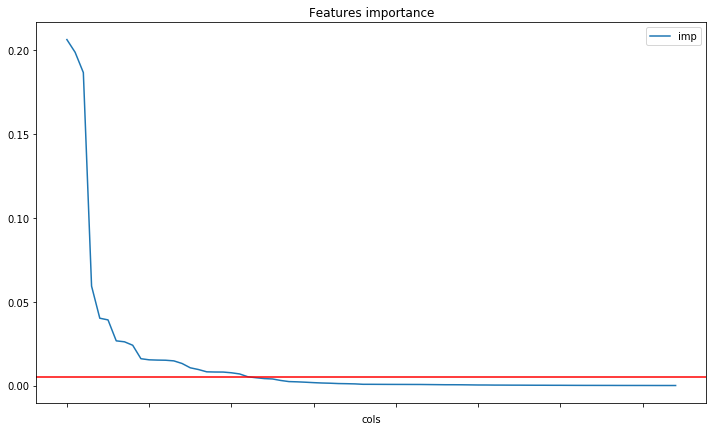

In [82]:
feat_importance.plot("cols", "imp", title="Features importance", figsize=(12,7))
plt.axhline(y=0.005, color="r")

From the above figure we can see that the features importance drop quickly and that the model use mainly 25% of the features.
We will drop features with importance less than 0.005

In [83]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

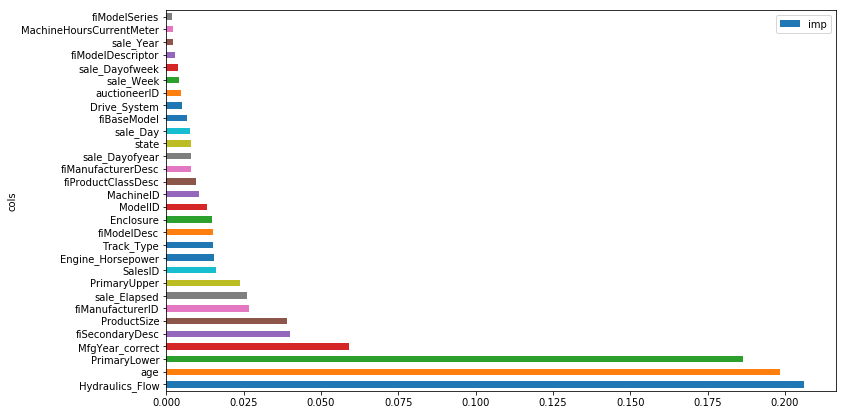

In [84]:
plot_feat_importance(feat_importance[:30])

In [85]:
feat_importance_keep = feat_importance[feat_importance.imp > .005]
len(feat_importance_keep)

23

In [86]:
with open(f"{DATA_DIR}keep_cols", "wb") as handle:
    pickle.dump(feat_importance_keep, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
df_keep = df_merge[feat_importance_keep.cols]
df_keep.head()

,Hydraulics_Flow,age,PrimaryLower,MfgYear_correct,fiSecondaryDesc,ProductSize,fiManufacturerID,sale_Elapsed,PrimaryUpper,SalesID,...,Enclosure,ModelID,MachineID,fiProductClassDesc,fiManufacturerDesc,sale_Dayofyear,state,sale_Day,fiBaseModel,Drive_System
0,2,2.0,110.0,2004.0,44,0,8,1163635200,120.0,1,...,3,652,60492,137,15,320,1,16,315,0
1,2,8.0,150.0,1996.0,61,4,9,1080259200,175.0,2,...,3,11,9294,140,16,86,33,26,568,0
2,3,3.0,1351.0,2001.0,0,0,9,1077753600,1601.0,3,...,6,1582,27886,105,16,57,32,26,118,0
3,3,3.0,1351.0,2001.0,0,0,9,1082678400,1601.0,87574,...,6,1582,27886,105,16,114,17,23,118,0
4,3,3.0,1351.0,2001.0,0,0,9,1079481600,1601.0,87575,...,6,1582,27886,105,16,77,44,17,118,0


In [88]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 23), (364147,), (12000, 23))

In [89]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 5min 13s, sys: 3.39 s, total: 5min 17s
Wall time: 52 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [90]:
#scores.drop("feat_importance", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"feat_importance": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [91]:
scores

,baseline,feat_importance_RF
RMSE train,0.077789,0.078666
RMSE valid,0.239067,0.240855
oob,0.908613,0.906005
score train,0.987229,0.986939
score valid,0.898389,0.896863


### Redundant features
In this section we are looking at redundant features, ie, features that are correlate to each other.
If there is some correlations, we only keep one of them.

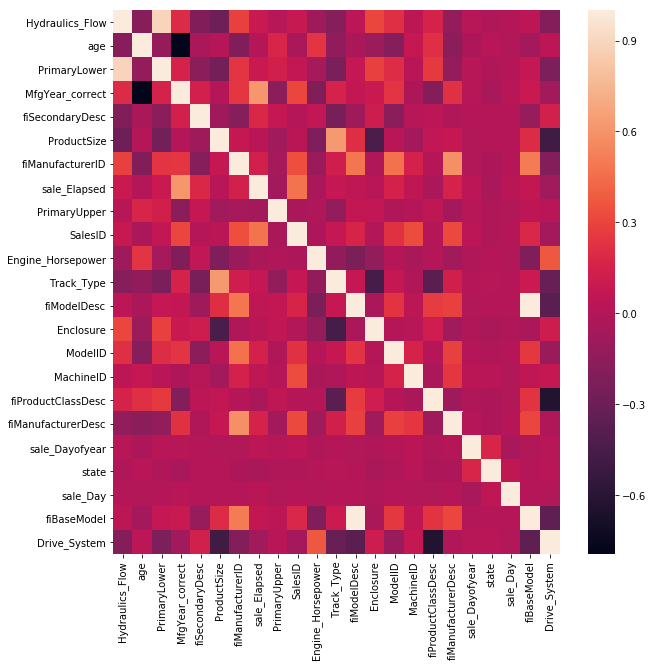

In [92]:
corr=df_keep.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The correlation matrix is not easy looking, let plot a dendrogram.

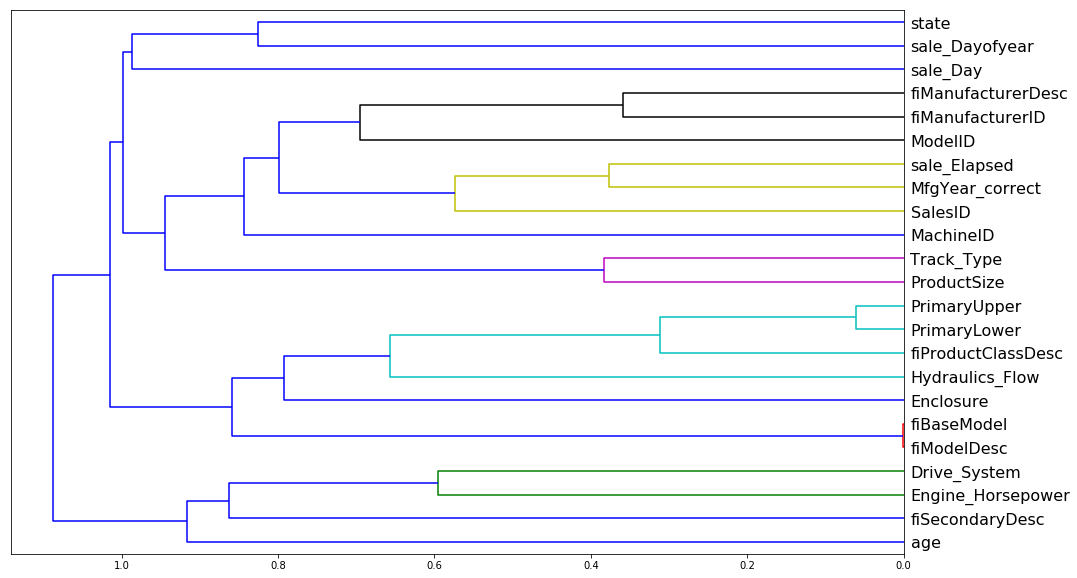

In [93]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

The dendrogram show that there is only one group of correlated features, fiBaseModel and fiModelDesc.
We are going to remove each of them one at the time and look how it's affect the oob score.
We'll remove the feature that has the less impact on the score.

In [94]:
def get_oob(df, y_train, n_trn):
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    rf.fit(x, y_train)
    return rf.oob_score_

In [95]:
get_oob(df_keep, y_train, n_trn)

0.90619522071224945

In [96]:
for col_name in ["fiBaseModel", "fiModelDesc"]:
    print(col_name+": ", get_oob(df_keep.drop(col_name, axis=1), y_train, n_trn))

fiBaseModel:  0.906173580189
fiModelDesc:  0.90619256598


In [97]:
dropped_columns = dropped_columns.join(df_keep["fiModelDesc"])

In [98]:
df_keep = df_keep.drop("fiModelDesc", axis=1)

In [99]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 22), (364147,), (12000, 22))

In [100]:
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 51s, sys: 3.01 s, total: 4min 54s
Wall time: 47 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [101]:
scores = scores.join(pd.DataFrame({"correlation": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [102]:
scores

,baseline,feat_importance_RF,correlation
RMSE train,0.077789,0.078666,0.078984
RMSE valid,0.239067,0.240855,0.239592
oob,0.908613,0.906005,0.905868
score train,0.987229,0.986939,0.986833
score valid,0.898389,0.896863,0.897943


In [103]:
df_keep.to_csv(f"{DATA_DIR}df_keep.csv", index=False)

In this section we only found one cluster of features that are correlated.
For each clusters we try to remove one features at the time to investigate the impact on the score. 
Finaly we choose to remove from the dataset the feature that had the most postive impact onthe score.

### Partial dependence plots
Partial dependence plots are useful to understand how a features impact the dependant variable.
It is a useful tool to understand the model.
In this section we look at the partial dependence plot for the most influencial features of the model.

In [104]:
df_keep = pd.read_csv(f"{DATA_DIR}df_keep.csv")

In [105]:
feat_importance = get_features_importance(random_forest, df_keep)

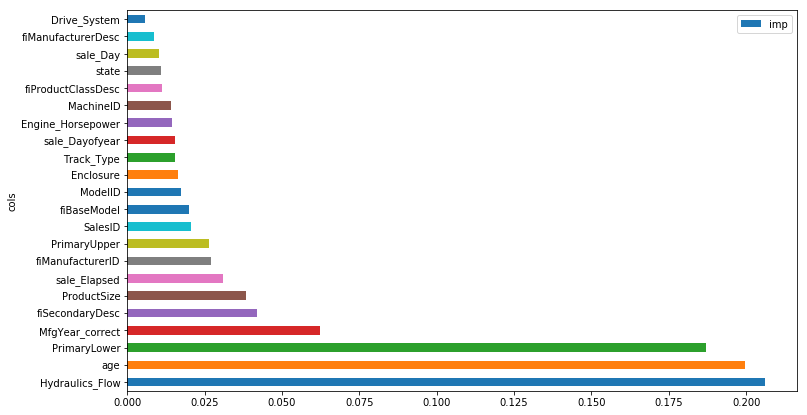

In [106]:
plot_feat_importance(feat_importance)

In [107]:
# No need to plot all the dataset, we are gonna use a random sample of it
def get_sample(df, n):
    """
    Return a sample of the data frame of size n.
    
    Inputs
    ===
    - df: the input data frame.
    - n: the size of the sample.
    
    Outputs
    ===
    - a data frame with a random sample of size n of the input data frame.
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [108]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(random_forest, x_train_aux, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [109]:
df_aux = df_keep.copy()
df_aux["SalePrice"] = sale_price
df_sample = get_sample(df_aux, 5000)

In [110]:
x_train_aux = get_sample(x_train, 1000)

{0: 'High Flow', 1: 'None or Unspecified', 2: 'Standard'}


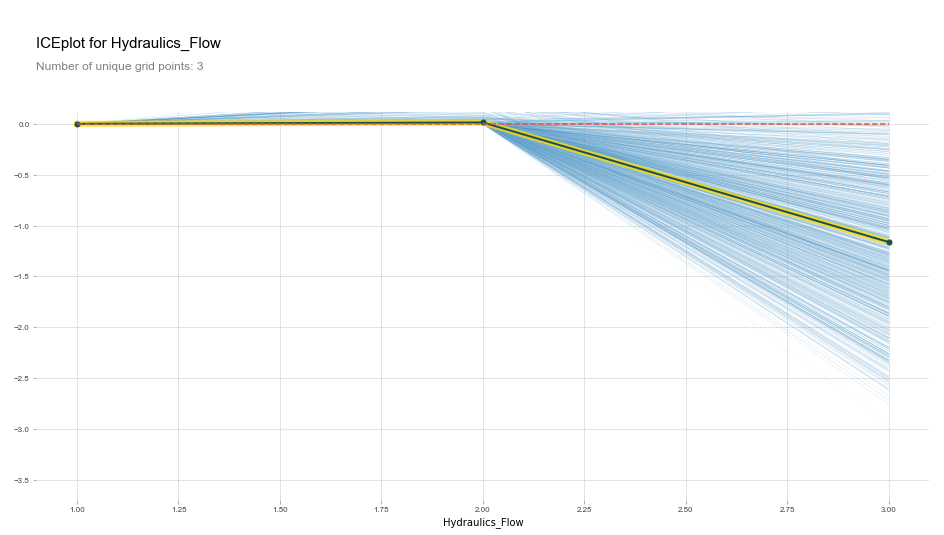

In [111]:
print(category_mapper["Hydraulics_Flow"])
plot_pdp('Hydraulics_Flow')

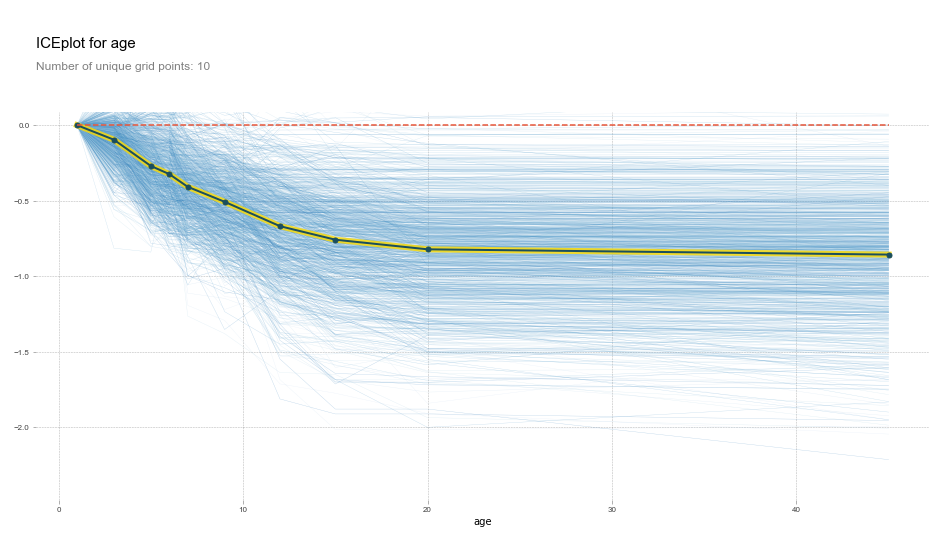

In [112]:
plot_pdp('age')

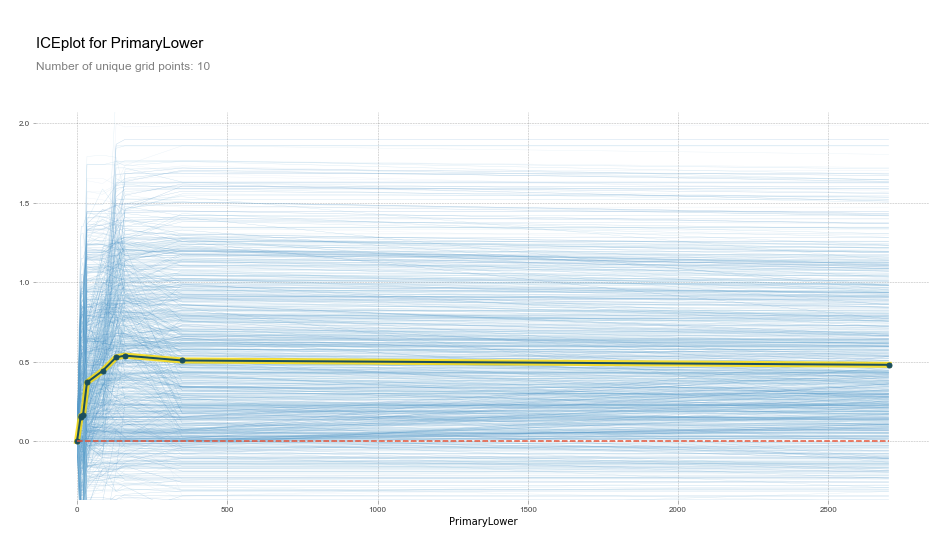

In [113]:
plot_pdp('PrimaryLower')

{'Compact': 0, 'Large': 1, 'Large / Medium': 2, 'Medium': 3, 'Mini': 4, 'Small': 5}


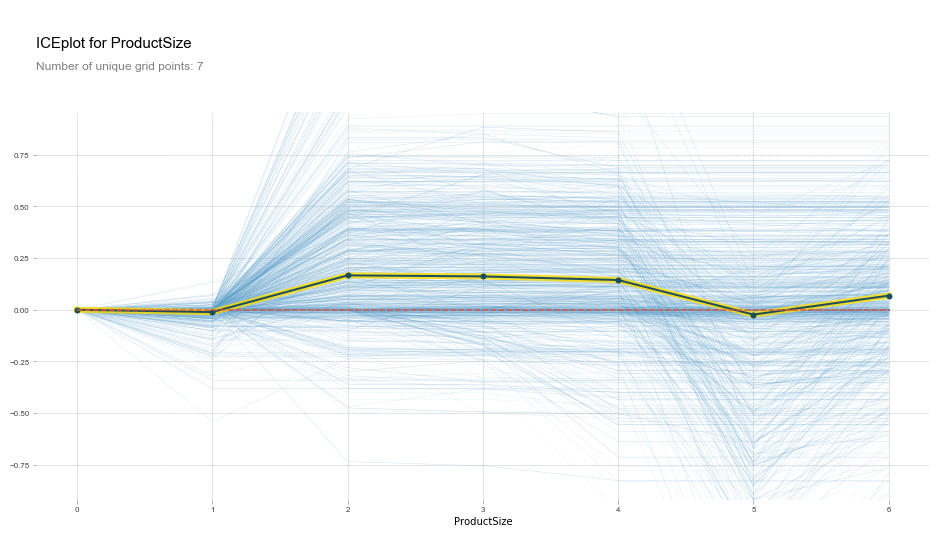

In [114]:
print(category_inv_mapper["ProductSize"])
plot_pdp("ProductSize")

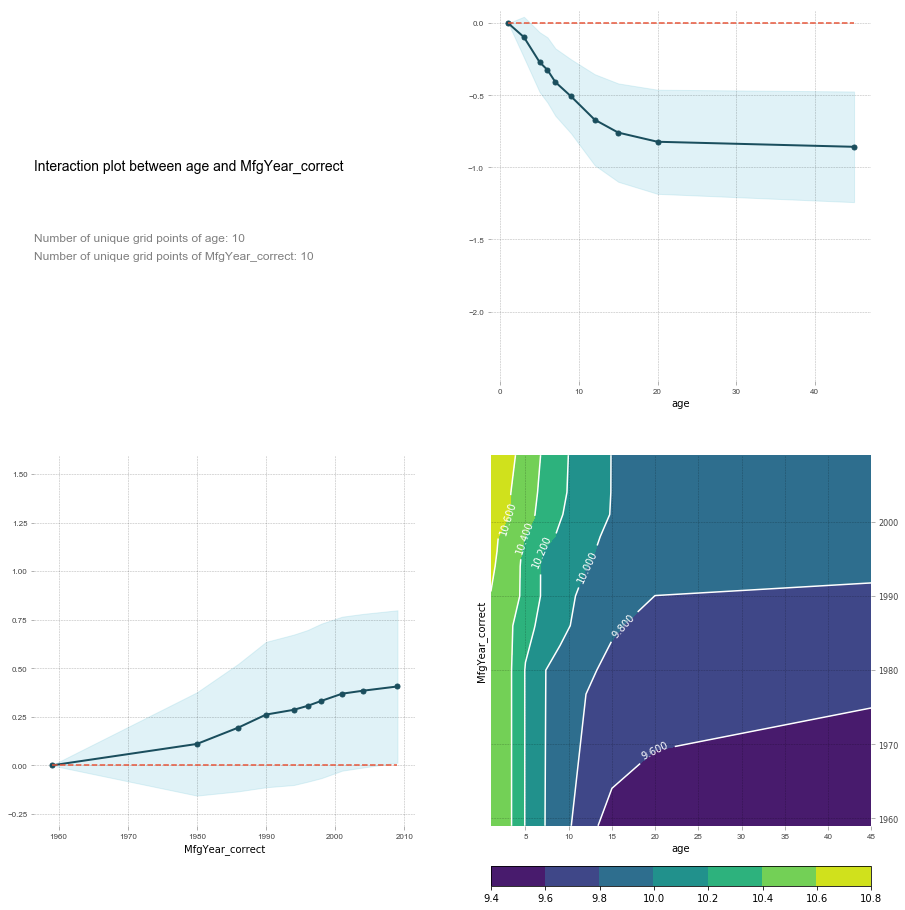

In [115]:
feats = ['age', 'MfgYear_correct']
p = pdp.pdp_interact(random_forest, x_train_aux, feats)
pdp.pdp_interact_plot(p, feats)

## Extrapolation
Random forest are not so good to extrapolate predictions.
To improve the accuracy of the model, we want to minimize the model dependence on temporal features.
For that we are going to investigate which of the major temporal features driving the model.
Next, we'll remove each of them one at the time and check on the score is impacted.

In [174]:
df_extra = df_keep.copy()
df_extra["is_valid"] = 1
df_extra["is_valid"].values[:n_trn] = 0
y = df_extra["is_valid"].values
df_extra.drop("is_valid", axis=1, inplace=True)

In [175]:
random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
random_forest.fit(df_extra, y);
random_forest.oob_score_

0.9966475872464754

In [179]:
feature_importance = pd.DataFrame({"cols": df_extra.columns, "imp": random_forest.feature_importances_}).sort_values("imp", ascending=False)
feature_importance[:10]

,cols,imp
9,SalesID,0.602341
7,sale_Elapsed,0.155036
14,MachineID,0.120929
17,sale_Dayofyear,0.016385
6,fiManufacturerID,0.015744
3,MfgYear_correct,0.011816
13,ModelID,0.010984
1,age,0.009805
20,fiBaseModel,0.009541
19,sale_Day,0.007525


In [180]:
#feats = ['SalesID', 'sale_Elapsed', 'MachineID']
feats = list(feature_importance.cols.values[:3])
feats

['SalesID', 'sale_Elapsed', 'MachineID']

In [181]:
df_extra.drop(feats, axis=1, inplace=True)

In [182]:
random_forest.fit(df_extra, y)
random_forest.oob_score_

0.97699037876149486

In [183]:
feature_importance = pd.DataFrame({"cols": df_extra.columns, "imp": random_forest.feature_importances_}).sort_values("imp", ascending=False)
feature_importance[:10]

,cols,imp
14,sale_Dayofyear,0.176971
1,age,0.154557
3,MfgYear_correct,0.141174
16,sale_Day,0.102008
15,state,0.089876
11,ModelID,0.066626
17,fiBaseModel,0.048349
6,fiManufacturerID,0.030306
12,fiProductClassDesc,0.029017
10,Enclosure,0.028098


In [184]:
#feats=['SalesID', 'sale_Elapsed', 'MachineID', 'age', 'sale_Dayofyear', "MfgYear_correct", "sale_Day"]
feats = feats + list(feat_importance["cols"].values[:3])
feats

['SalesID',
 'sale_Elapsed',
 'MachineID',
 'Hydraulics_Flow',
 'age',
 'PrimaryLower']

In [185]:
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [186]:
scores_extra = pd.DataFrame({"baseline": get_scores(random_forest, x_train, y_train, x_valid, y_valid)})

In [187]:
scores_extra

,baseline
RMSE train,0.078757
RMSE valid,0.239856
oob,0.906038
score train,0.986909
score valid,0.897718


In [188]:
for f in feats:
    print(f)
    df_subs = df_keep.drop(f, axis=1)
    x_train, x_valid = split_vals(df_subs, n_trn)
    y_train, y_valid = split_vals(sale_price, n_trn)
    random_forest.fit(x_train, y_train)
    scores_extra = scores_extra.join(pd.DataFrame({f: get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

SalesID
sale_Elapsed
MachineID
Hydraulics_Flow
age
PrimaryLower


In [189]:
scores_extra

,baseline,SalesID,sale_Elapsed,MachineID,Hydraulics_Flow,age,PrimaryLower
RMSE train,0.078757,0.078903,0.080663,0.078410,0.078790,0.078956,0.078839
RMSE valid,0.239856,0.231554,0.247009,0.238995,0.240995,0.243345,0.240582
oob,0.906038,0.905515,0.901229,0.906906,0.905724,0.905462,0.905920
score train,0.986909,0.986860,0.986267,0.987024,0.986898,0.986842,0.986881
score valid,0.897718,0.904676,0.891526,0.898450,0.896744,0.894720,0.897097


In [190]:
scores_extra.loc[["score valid", "RMSE valid"]].transpose().sort_values("score valid", ascending=False)

,score valid,RMSE valid
SalesID,0.904676,0.231554
MachineID,0.898450,0.238995
baseline,0.897718,0.239856
PrimaryLower,0.897097,0.240582
Hydraulics_Flow,0.896744,0.240995
age,0.894720,0.243345
sale_Elapsed,0.891526,0.247009


From the above table we can deduce that removing the features SalesID, MachineID improve the model. However age and sale_Elapsed greatly impact on the RMSE score.
We'll try PrimaryLower and Hydraulics_Flow once we removed SalesID and MachineID.

In [191]:
df_final = df_keep.drop(["SalesID", "MachineID"], axis=1)

In [199]:
x_train, x_valid = split_vals(df_final, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 3min 54s, sys: 3.02 s, total: 3min 57s
Wall time: 40.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [201]:
#scores.drop("extra", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"extra": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [202]:
scores

,baseline,feat_importance_RF,correlation,extra
RMSE train,0.077789,0.078666,0.078984,0.083496
RMSE valid,0.239067,0.240855,0.239592,0.228516
oob,0.908613,0.906005,0.905868,0.906921
score train,0.987229,0.986939,0.986833,0.985286
score valid,0.898389,0.896863,0.897943,0.907160


In [203]:
scores_extra = pd.DataFrame()
scores_extra["baseline"] = scores["extra"]
scores_extra

,baseline
RMSE train,0.083496
RMSE valid,0.228516
oob,0.906921
score train,0.985286
score valid,0.907160


In [204]:
for f in ["PrimaryLower", "Hydraulics_Flow"]:
    print(f)
    df_subs = df_keep.drop(f, axis=1)
    x_train, x_valid = split_vals(df_subs, n_trn)
    y_train, y_valid = split_vals(sale_price, n_trn)
    random_forest.fit(x_train, y_train)
    scores_extra = scores_extra.join(pd.DataFrame({f: get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

PrimaryLower
Hydraulics_Flow


In [205]:
scores_extra.loc[["score valid", "RMSE valid"]].transpose().sort_values("score valid", ascending=False)

,score valid,RMSE valid
baseline,0.907160,0.228516
Hydraulics_Flow,0.898753,0.238639
PrimaryLower,0.897701,0.239875


Removing the features Hydraulics_Flow and PrimaryLower would increase the RMSE, so keep them.

## Final model

In [280]:
test_fold = [-1 for _ in range(len(x_train))] + [0 for _ in range(len(x_valid))]
len(test_fold) == len(df_final)

True

In [281]:
ps = PredefinedSplit(test_fold)

In [282]:
params = {"n_estimators": [100, 150], "max_features": [.5, 1.0, "sqrt"], "max_leaf_nodes":[None, 3, 10]}

In [283]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)    

In [284]:
random_forest = RandomForestRegressor(n_jobs=-1)

In [285]:
clf = GridSearchCV(random_forest, params, cv=PredefinedSplit(test_fold),
#                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=10)

In [286]:
clf.fit(df_final, sale_price)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV] max_features=0.5, max_leaf_nodes=1, n_estimators=100 ............


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/bastien/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10b5c8930, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/bastien/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/basti.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10b5c8930, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/bastien/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/basti.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf.fit(df_final, sale_price)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 28, 12, 15, 45, 44442, tzinfo=tzutc()), 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'session': '90AEAE3E7B4B44038C00354ABDA8BB10', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'90AEAE3E7B4B44038C00354ABDA8BB10']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf.fit(df_final, sale_price)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 28, 12, 15, 45, 44442, tzinfo=tzutc()), 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'session': '90AEAE3E7B4B44038C00354ABDA8BB10', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'90AEAE3E7B4B44038C00354ABDA8BB10'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'clf.fit(df_final, sale_price)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 28, 12, 15, 45, 44442, tzinfo=tzutc()), 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'session': '90AEAE3E7B4B44038C00354ABDA8BB10', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F7AA0837C0B74027BA41907343CBAFC2', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='clf.fit(df_final, sale_price)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'clf.fit(df_final, sale_price)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('clf.fit(df_final, sale_price)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('clf.fit(df_final, sale_price)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='clf.fit(df_final, sale_price)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-286-d9fe432b26fd>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c991ae710, execution..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1c172448a0, file "<ipython-input-286-d9fe432b26fd>", line 1>
        result = <ExecutionResult object at 1c991ae710, execution..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1c172448a0, file "<ipython-input-286-d9fe432b26fd>", line 1>, result=<ExecutionResult object at 1c991ae710, execution..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1c172448a0, file "<ipython-input-286-d9fe432b26fd>", line 1>
        self.user_global_ns = {'DATA_DIR': 'data/', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('load_ext autoreload')\nget_i...load 2')\nget_ipython().magic('matplotlib inline')", 'import re\nimport os\nimport pandas as pd\nimport n...port treeinterpreter as ti\nimport waterfall_chart', 'DATA_DIR = "data/"\nos.listdir(DATA_DIR)', 'get_ipython().magic(\'time df_train_raw = pd.read...TA_DIR}Machine_Appendix.csv", low_memory=False)\')', 'df_train_raw.to_feather(f"{DATA_DIR}Train.frt")\n...ppendix_raw.to_feather(f"{DATA_DIR}appendix.frt")', 'get_ipython().magic(\'time df_train_raw = pd.read...aw = pd.read_feather(f"{DATA_DIR}appendix.frt")\')', 'df_merge_raw = pd.merge(df_train_raw, df_appendi...train_raw.columns)\nprint(df_appendix_raw.columns)', 'df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")', 'df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")', 'df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")', 'del df_train_raw\ndel df_appendix_raw', 'df_merge_raw.columns', 'duplicate_columns = ["fiModelDesc", "fiBaseModel...l().sum() for col_name in duplicate_columns}\ntemp', 'ok_columns = [key for key, val in temp.items() i...snull().sum()] for col_name in duplicate_columns}', 'df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)', 'for col_name in duplicate_columns:\n    df_merge[...f_merge.drop(col_name+"_y", axis=1, inplace=True)', '# Let save the dataframe\ndf_merge.to_feather(f"{DATA_DIR}df_merge.frt")', 'del df_merge_raw', 'df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")', ...], 'MfgYear_idx': Int64Index([    39,     41,     53,     77,     ... 401073],
           dtype='int64', length=22554), 'Out': {3: ['df_process.frt', 'Valid.csv', 'category_mapper', '.DS_Store', 'merge_raw.frt', 'df_merge_3.csv', 'df_keep.frt', 'train.frt', 'df_process_2.frt', 'Machine_Appendix.csv', 'Train.csv', 'df_keep.csv', 'df_merge.frt', 'df_merge_2.frt', 'df_merge_3.frt', 'dropped_cols.frt', 'appendix.frt', 'df_merge_4.frt', 'keep_cols', 'train.ftr'], 12: Index(['SalesID', 'SalePrice', 'MachineID', 'Mod...r',
       'PrimaryUpper'],
      dtype='object'), 13: {'ModelID': True, 'ProductGroup': True, 'ProductGroupDesc': True, 'fiBaseModel': True, 'fiModelDesc': True, 'fiModelDescriptor': False, 'fiModelSeries': False, 'fiProductClassDesc': True, 'fiSecondaryDesc': False}, 14: {'ModelID': [0, 0], 'ProductGroup': [0, 0], 'ProductGroupDesc': [0, 0], 'fiBaseModel': [0, 0], 'fiModelDesc': [0, 0], 'fiModelDescriptor': [329206, 326906], 'fiModelSeries': [344217, 343515], 'fiProductClassDesc': [0, 0], 'fiSecondaryDesc': [137191, 135593]}, 21:                            Total  Percentage
Pus...0.08
MfgYear                      256        0.06, 22: 33864, 24:         SalesID  SalePrice  MachineID  datasourc...        Skidders    4839  

[1 rows x 59 columns], 28: [], 29: <matplotlib.axes._subplots.AxesSubplot object>, 30: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'PredefinedSplit': <class 'sklearn.model_selection._split.PredefinedSplit'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'YearMade_idx': Int64Index([    12,     15,     27,     39,     ... 401076],
           dtype='int64', length=38185), '_': True, ...}
        self.user_ns = {'DATA_DIR': 'data/', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('load_ext autoreload')\nget_i...load 2')\nget_ipython().magic('matplotlib inline')", 'import re\nimport os\nimport pandas as pd\nimport n...port treeinterpreter as ti\nimport waterfall_chart', 'DATA_DIR = "data/"\nos.listdir(DATA_DIR)', 'get_ipython().magic(\'time df_train_raw = pd.read...TA_DIR}Machine_Appendix.csv", low_memory=False)\')', 'df_train_raw.to_feather(f"{DATA_DIR}Train.frt")\n...ppendix_raw.to_feather(f"{DATA_DIR}appendix.frt")', 'get_ipython().magic(\'time df_train_raw = pd.read...aw = pd.read_feather(f"{DATA_DIR}appendix.frt")\')', 'df_merge_raw = pd.merge(df_train_raw, df_appendi...train_raw.columns)\nprint(df_appendix_raw.columns)', 'df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")', 'df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")', 'df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")', 'del df_train_raw\ndel df_appendix_raw', 'df_merge_raw.columns', 'duplicate_columns = ["fiModelDesc", "fiBaseModel...l().sum() for col_name in duplicate_columns}\ntemp', 'ok_columns = [key for key, val in temp.items() i...snull().sum()] for col_name in duplicate_columns}', 'df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)', 'for col_name in duplicate_columns:\n    df_merge[...f_merge.drop(col_name+"_y", axis=1, inplace=True)', '# Let save the dataframe\ndf_merge.to_feather(f"{DATA_DIR}df_merge.frt")', 'del df_merge_raw', 'df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")', ...], 'MfgYear_idx': Int64Index([    39,     41,     53,     77,     ... 401073],
           dtype='int64', length=22554), 'Out': {3: ['df_process.frt', 'Valid.csv', 'category_mapper', '.DS_Store', 'merge_raw.frt', 'df_merge_3.csv', 'df_keep.frt', 'train.frt', 'df_process_2.frt', 'Machine_Appendix.csv', 'Train.csv', 'df_keep.csv', 'df_merge.frt', 'df_merge_2.frt', 'df_merge_3.frt', 'dropped_cols.frt', 'appendix.frt', 'df_merge_4.frt', 'keep_cols', 'train.ftr'], 12: Index(['SalesID', 'SalePrice', 'MachineID', 'Mod...r',
       'PrimaryUpper'],
      dtype='object'), 13: {'ModelID': True, 'ProductGroup': True, 'ProductGroupDesc': True, 'fiBaseModel': True, 'fiModelDesc': True, 'fiModelDescriptor': False, 'fiModelSeries': False, 'fiProductClassDesc': True, 'fiSecondaryDesc': False}, 14: {'ModelID': [0, 0], 'ProductGroup': [0, 0], 'ProductGroupDesc': [0, 0], 'fiBaseModel': [0, 0], 'fiModelDesc': [0, 0], 'fiModelDescriptor': [329206, 326906], 'fiModelSeries': [344217, 343515], 'fiProductClassDesc': [0, 0], 'fiSecondaryDesc': [137191, 135593]}, 21:                            Total  Percentage
Pus...0.08
MfgYear                      256        0.06, 22: 33864, 24:         SalesID  SalePrice  MachineID  datasourc...        Skidders    4839  

[1 rows x 59 columns], 28: [], 29: <matplotlib.axes._subplots.AxesSubplot object>, 30: <matplotlib.axes._subplots.AxesSubplot object>, ...}, 'PredefinedSplit': <class 'sklearn.model_selection._split.PredefinedSplit'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'YearMade_idx': Int64Index([    12,     15,     27,     39,     ... 401076],
           dtype='int64', length=38185), '_': True, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/bastien/work/bulldozers/<ipython-input-286-d9fe432b26fd> in <module>()
----> 1 clf.fit(df_final, sale_price)

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=PredefinedSplit(test_fold=array(...in_score='warn',
       scoring=None, verbose=10), X=        Hydraulics_Flow   age  PrimaryLower  Mfg...76146             0  

[376147 rows x 20 columns], y=0         11.097410
1         10.950807
2       ...8
Name: SalePrice, Length: 376147, dtype: float64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method PredefinedSplit.split of PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))>
        X =         Hydraulics_Flow   age  PrimaryLower  Mfg...76146             0  

[376147 rows x 20 columns]
        y = 0         11.097410
1         10.950807
2       ...8
Name: SalePrice, Length: 376147, dtype: float64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseSearchCV.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False),         Hydraulics_Flow   age  PrimaryLower  Mfg...76146             0  

[376147 rows x 20 columns], 0         11.097410
1         10.950807
2       ...8
Name: SalePrice, Length: 376147, dtype: float64, {'score': <function _passthrough_scorer>}, array([     0,      1,      2, ..., 364144, 364145, 364146]), array([364147, 364148, 364149, ..., 376144, 376145, 376146]), 10, {'max_features': 0.5, 'max_leaf_nodes': 1, 'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False),         Hydraulics_Flow   age  PrimaryLower  Mfg...76146             0  

[376147 rows x 20 columns], 0         11.097410
1         10.950807
2       ...8
Name: SalePrice, Length: 376147, dtype: float64, {'score': <function _passthrough_scorer>}, array([     0,      1,      2, ..., 364144, 364145, 364146]), array([364147, 364148, 364149, ..., 376144, 376145, 376146]), 10, {'max_features': 0.5, 'max_leaf_nodes': 1, 'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=        Hydraulics_Flow   age  PrimaryLower  Mfg...76146             0  

[376147 rows x 20 columns], y=0         11.097410
1         10.950807
2       ...8
Name: SalePrice, Length: 376147, dtype: float64, scorer={'score': <function _passthrough_scorer>}, train=array([     0,      1,      2, ..., 364144, 364145, 364146]), test=array([364147, 364148, 364149, ..., 376144, 376145, 376146]), verbose=10, parameters={'max_features': 0.5, 'max_leaf_nodes': 1, 'n_estimators': 100}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestRegr...te=None,
           verbose=0, warm_start=False)>
        X_train =         Hydraulics_Flow   age  PrimaryLower  Mfg...64146             0  

[364147 rows x 20 columns]
        y_train = 0         11.097410
1         10.950807
2       ...9
Name: SalePrice, Length: 364147, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), y=array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 99
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Feb 28 13:15:45 2018
PID: 17302                Python 3.6.3: /Users/bastien/anaconda3/bin/python
...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...t=False, random_state=833350899, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), None, 0, 100), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...t=False, random_state=833350899, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), None, 0, 100)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...t=False, random_state=833350899, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), y=array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), sample_weight=None, tree_idx=0, n_trees=100, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...=False, random_state=833350899, splitter='best')>
        X = array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32)
        y = array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]])
        sample_weight = None
        curr_sample_weight = array([ 1.,  0.,  0., ...,  0.,  0.,  0.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...t=False, random_state=833350899, splitter='best'), X=array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), y=array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), sample_weight=array([ 1.,  0.,  0., ...,  0.,  0.,  0.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
/Users/bastien/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...t=False, random_state=833350899, splitter='best'), X=array([[    2.,     2.,   110., ...,    16.,   3...8., ...,    16.,  1493.,     0.]], dtype=float32), y=array([[ 11.09741002],
       [ 10.95080655],
  ...],
       [ 10.59663473],
       [ 10.08580911]]), sample_weight=array([ 1.,  0.,  0., ...,  0.,  0.,  0.]), check_input=False, X_idx_sorted=None)
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:
    247             raise ValueError(("max_leaf_nodes {0} must be either None "
--> 248                               "or larger than 1").format(max_leaf_nodes))
        max_leaf_nodes = 1
    249 
    250         if sample_weight is not None:
    251             if (getattr(sample_weight, "dtype", None) != DOUBLE or
    252                     not sample_weight.flags.contiguous):

ValueError: max_leaf_nodes 1 must be either None or larger than 1
___________________________________________________________________________

In [271]:
clf.best_params_

{'max_features': 0.5, 'n_estimators': 150}

In [272]:
x_train, x_valid = split_vals(df_final, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

In [273]:
random_forest = RandomForestRegressor(n_estimators=150, max_features=.5, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 5min 44s, sys: 8.43 s, total: 5min 52s
Wall time: 58.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [274]:
get_scores(random_forest, x_train, y_train, x_valid, y_valid)

{'RMSE train': 0.0799165528373259,
 'RMSE valid': 0.22199381044959923,
 'oob': 0.91398518857607225,
 'score train': 0.98652034835676861,
 'score valid': 0.91238425122453537}

In [211]:
scores = scores.join(pd.DataFrame({"final": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [212]:
scores

,baseline,feat_importance_RF,correlation,extra,final
RMSE train,0.077789,0.078666,0.078984,0.083496,0.081307
RMSE valid,0.239067,0.240855,0.239592,0.228516,0.226884
oob,0.908613,0.906005,0.905868,0.906921,0.910661
score train,0.987229,0.986939,0.986833,0.985286,0.986047
score valid,0.898389,0.896863,0.897943,0.907160,0.908482


In [213]:
df_final.to_csv(f"{DATA_DIR}df_final.csv", index=False)

## Tree interpretation

In [229]:
prediction, bias, contributions = ti.predict(random_forest, x_valid.values[None,110])

In [230]:
prediction[0], bias[0], contributions[0]

(9.6042457548924887,
 10.13520285699887,
 array([ 0.05209777,  0.02093287, -0.37548048,  0.07984081, -0.00690583,
        -0.04460053, -0.01544301, -0.04772552, -0.2005911 ,  0.        ,
         0.06394164, -0.01771015, -0.00839779, -0.03630454, -0.00490389,
         0.01528618, -0.00107445,  0.00750637, -0.02410794,  0.01268246]))

In [231]:
idxs = np.argsort(contributions[0])

In [232]:
[o for o in zip(df_final.columns[idxs], x_valid.iloc[0][idxs], contributions[0][idxs])]

[('PrimaryLower', 14.0, -0.37548047993547967),
 ('PrimaryUpper', 16.0, -0.20059109709147299),
 ('sale_Elapsed', 1323216000.0, -0.047725515346960748),
 ('ProductSize', 6.0, -0.044600526887748668),
 ('fiProductClassDesc', 51.0, -0.036304535172322287),
 ('fiBaseModel', 1493.0, -0.024107935928476296),
 ('Enclosure', 3.0, -0.017710146573832394),
 ('fiManufacturerID', 25.0, -0.015443006872858947),
 ('ModelID', 5289.0, -0.0083977936161632009),
 ('fiSecondaryDesc', 44.0, -0.0069058266680224988),
 ('fiManufacturerDesc', 42.0, -0.0049038915732309181),
 ('state', 7.0, -0.0010744542704268678),
 ('Engine_Horsepower', 0.0, 0.0),
 ('sale_Day', 7.0, 0.0075063736535533202),
 ('Drive_System', 0.0, 0.012682460573464151),
 ('sale_Dayofyear', 341.0, 0.015286182435769903),
 ('age', 6.0, 0.020932873822353582),
 ('Hydraulics_Flow', 2.0, 0.052097771565432723),
 ('Track_Type', 2.0, 0.063941638522551567),
 ('MfgYear_correct', 2005.0, 0.079840807257489391)]

<module 'matplotlib.pyplot' from '/Users/bastien/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

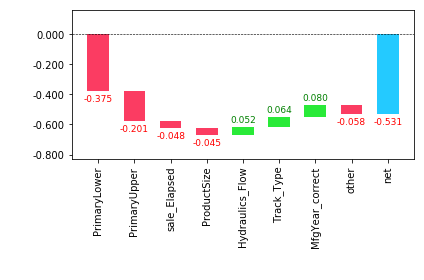

In [233]:
waterfall_chart.plot(df_final.columns[idxs], contributions[0][idxs], rotation_value=90, threshold=0.1, formatting='{:,.3f}')